In [5]:
# Must be run from curated_data folder
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker

from sklearn.decomposition import PCA
from scipy.signal import butter, filtfilt

# to print floating format
np.set_printoptions(suppress=True)

df_accel = pd.read_csv("all_accel_preprocessed.txt", index_col="timestamp")
df_shackles = pd.read_csv("all_shackles_preprocessed.txt", index_col="timestamp")
df_depths = pd.read_csv("all_depths.txt", index_col="timestamp")

df_accel.index = pd.to_datetime(df_accel.index)
df_shackles.index = pd.to_datetime(df_shackles.index)
df_depths.index = pd.to_datetime(df_depths.index)

df_joined1 = pd.merge(df_accel, df_shackles, on="timestamp", how="inner")
df_joined2 = pd.merge(df_joined1, df_depths, on="timestamp", how="inner")

analysis_datetimes = []
with open("analysis_dates.txt", "r") as f:
        for line in f.readlines():
            analysis_datetimes.append(pd.to_datetime(line))

In [125]:
# Plotting raw sensor data.
def plot_sensor_data(df, start_datetime=None, end_datetime=None, selected_sensors=None, save_fig=False,
                     ylabel=None, xlabel="Time", title="plot_sensor_data"):
    # If datetimes aren't specified, use first and last dates in df
    if start_datetime == None: start_datetime = df.index[0]
    if end_datetime == None: end_datetime = df.index[-1]

    # If sensor indices aren't specified, use all sensors.
    # Note that selected_sensors should be INDICES, not sensor numbers. i.e., sensor number 1 has index 0.
    if selected_sensors == None: selected_sensors = np.arange(len(df.columns))

    df_subset = df.loc[start_datetime:end_datetime]
    fig, ax = plt.subplots(figsize=(8,5))
    selected_columns = [df_subset.columns[i] for i in selected_sensors]

    ax.plot(df_subset[selected_columns], label=selected_columns, linewidth=1)
    plt.title(f"{title}")
    plt.legend(loc="upper right", bbox_to_anchor=(1, 1))
    
    time_range = end_datetime - start_datetime
    
    if time_range.days < 1:
        # Set the x-axis to display hours and minutes, with major ticks every 15 minutes and minor every 5 minutes.
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=15))
        ax.xaxis.set_minor_locator(mdates.MinuteLocator(interval=5))
    else:    
        # Set the x-axis to display month and day only, with major ticks every 3 days and minor every day
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m'))
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
        ax.xaxis.set_minor_locator(mdates.DayLocator(interval=1))
        ax.set_xlim([start_datetime - datetime.timedelta(days = 1), end_datetime + datetime.timedelta(days = 1)])
        
    # Make plot span entire x-axis
    ax.set_xlim([start_datetime, end_datetime])
    
    # Labels
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    
    # Rotate text for readability and remove minor tick labels
    plt.xticks(rotation=60)
    ax.xaxis.set_minor_formatter(mticker.NullFormatter())
    
    if save_fig:
        plt.savefig(f"./plots/{title}")
    
    plt.show()
        
    return

In [7]:
def perform_pca(dataframe, start_datetime, end_datetime, pca_thresh=0.95, save_fig=False, title="PCA - wtfsensor"):
    # Filter the data between the two datetimes
    filtered_data = dataframe.loc[start_datetime:end_datetime]

    # Standardize the data
    standardized_data = (filtered_data - filtered_data.mean()) / filtered_data.std()

    # Perform PCA
    pca = PCA()
    pca_data = pca.fit_transform(standardized_data)
    cumulative_pca = np.cumsum(pca.explained_variance_ratio_)

    # Find how many sensors are required for at least pca_thresh% PCA explained variance
    best_sensors = next(i for i, value in enumerate(cumulative_pca) if value > pca_thresh) + 1 # +1 to include last element
    eigenvectors = pca.components_
    abs_eigenvectors = np.abs(eigenvectors[:best_sensors]) # Don't include more than neccessary, sensitive to noise
    sensor_importance = np.sum(abs_eigenvectors, axis=0)
    top_sensors_indices = np.flip(np.argsort(sensor_importance))[:best_sensors] # Most important sensors (indices) from left to right

    print(f"PCA values {cumulative_pca}\nBest sensor indices (most important first) {top_sensors_indices}")
    
    # Plot explained variance ratio
    plt.figure()
    plt.plot(np.arange(np.size(cumulative_pca))+1, cumulative_pca)

    plt.xticks(np.arange(np.size(cumulative_pca))+1)
    plt.grid(color='gray', linestyle='-', linewidth=0.5, alpha=0.5)
    plt.xlabel('Number of Sensors')
    plt.ylabel('Cumulative Explained Variance')
    plt.title(f"{title}")
    
    if save_fig:
        plt.savefig(f"./plots/{title}")
        
    plt.show()

    return top_sensors_indices

In [8]:
def reconstruct_pca(dataframe, start_datetime, end_datetime, start_datetime2, end_datetime2, top_sensors_indices):
    # Filter the data between the two datetimes
    filtered_data = dataframe.loc[start_datetime:end_datetime]
    filtered_data2 = dataframe.loc[start_datetime2:end_datetime2].iloc[:, top_sensors_indices]

    # Standardize the data
    standardized_data = (filtered_data - filtered_data.mean()) / filtered_data.std()
    # standardized_data2 = (filtered_data2 - filtered_data2.mean()) / filtered_data2.std()
    standardized_data2 = (filtered_data2 - filtered_data.mean()[top_sensors_indices]) / filtered_data.std()[top_sensors_indices]
    
    # Perform PCA
    pca = PCA()
    pca_fit = pca.fit(standardized_data)
    comps = pca_fit.components_[top_sensors_indices,:]
    
    pca_data2 = pca.fit_transform(standardized_data2)
    
    x_hat = np.dot(pca_data2, comps)
    x_hat = x_hat * filtered_data.std().to_numpy() + filtered_data.mean().to_numpy()
    
    # Overwrite the estimation of sensors that were used in reconstructing, we know these to be correct.
    x_hat[:,top_sensors_indices] = filtered_data2
    
    return x_hat

In [ ]:
# Plot depth data
start = analysis_datetimes[0] - datetime.timedelta(minutes=45)
end = analysis_datetimes[-1] + datetime.timedelta(minutes=45)
plot_sensor_data(df_depths, start, end, save_fig=True, ylabel="Depth [m]", title="Depth sensors preprocessed")

PCA values [0.78953294 0.86735323 0.91885266 0.93675114 0.95064317 0.95949084
 0.96688402 0.97322101 0.97910165 0.98428811 0.98830579 0.99168565
 0.99478457 0.99765775 1.        ]
Best sensor indices (most important first) [ 1  9  3 11  0]


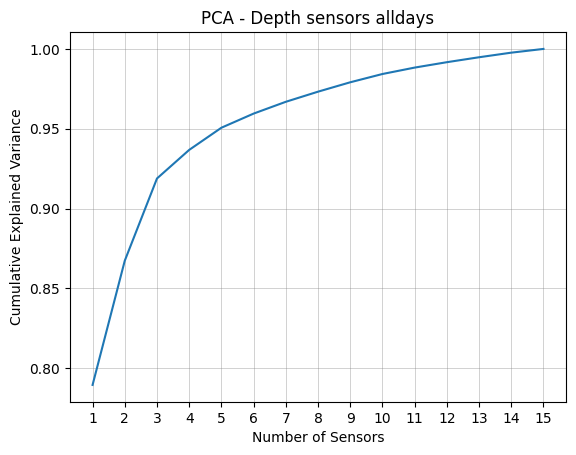

In [75]:
# PCA for depths and also trying to reconstruct all data
i=5
start = analysis_datetimes[i] - datetime.timedelta(minutes=45)
end = analysis_datetimes[i] + datetime.timedelta(minutes=45)
start_test = analysis_datetimes[8] - datetime.timedelta(minutes=45)
end_test = analysis_datetimes[8] + datetime.timedelta(minutes=45)

top_sensors_indices = perform_pca(df_depths, start, end, save_fig=True, title=f"PCA - Depth sensors day {i+1}")
# reconstructed_data = reconstruct_pca(df_depths, start, end, start_test, end_test, top_sensors_indices)

# errors = df_depths.loc[start_test:end_test, :] - reconstructed_data
# RSS = np.linalg.norm(errors, ord=2)
# print(f"Residual sum of squares = {np.round(RSS,2)}")

# plot_sensor_data(errors, title="Reconstructed depth sensors error")

In [10]:
def low_pass_filter_dataframe(dataframe, cutoff_frequency, sampling_rate, filter_order=4):
    # Design the low-pass Butterworth filter
    nyquist_freq = 0.5 * sampling_rate
    normalized_cutoff_freq = cutoff_frequency / nyquist_freq
    b, a = butter(filter_order, normalized_cutoff_freq, btype='low')

    # Apply the filter to each column of the DataFrame
    filtered_dataframe = dataframe.copy()
    for column in dataframe.columns:
        filtered_dataframe[column] = filtfilt(b, a, dataframe[column])

    return filtered_dataframe

In [ ]:
# PCA for joined data
start = analysis_datetimes[0] - datetime.timedelta(minutes=45)
end = analysis_datetimes[0] + datetime.timedelta(minutes=45)
plot_sensor_data(df_joined1[::4*5], start, end, save_fig=False, title="Accel and load shackles")

top_sensors_indices = perform_pca(df_joined1, start, end, save_fig=False, title="PCA - Accel. and load shackles")
# reconstructed_data = reconstruct_pca(df_depths, start, end, start_test, end_test, top_sensors_indices)

In [ ]:
# Plot accelerometer data
start = analysis_datetimes[0] - datetime.timedelta(minutes=45)
end = analysis_datetimes[0] + datetime.timedelta(minutes=45)
plot_sensor_data(df_accel[::8*5], start, end, save_fig=True, ylabel="G-forces [g]", title="Accelerometers preprocessed day 1")

PCA values [0.16541103 0.32466884 0.46728559 0.60876847 0.74640405 0.87387697
 1.        ]
Best sensor indices (most important first) [6 4 3 2 5 1 0]


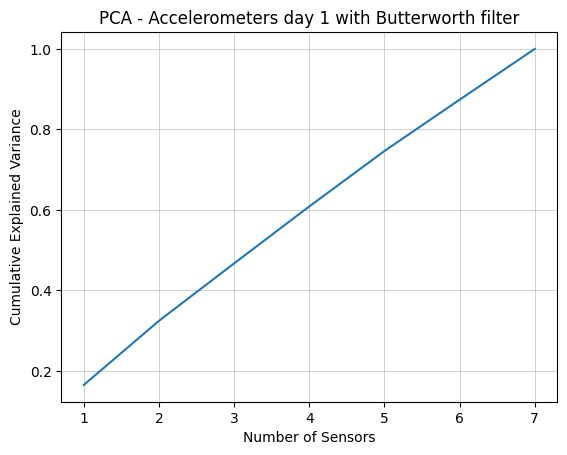

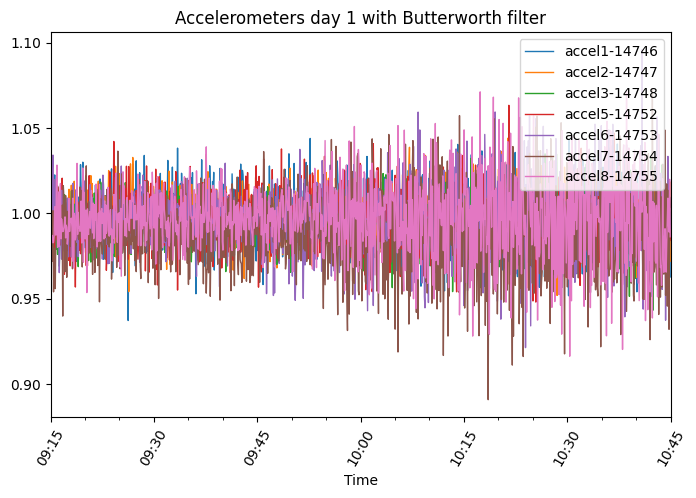

In [128]:
# PCA for accelerometers
i=0
start = analysis_datetimes[i] - datetime.timedelta(minutes=45)
end = analysis_datetimes[i] + datetime.timedelta(minutes=45)

df_accel_avg = df_accel.rolling(window=8*10, axis=0).mean()
df_accel_filtered = low_pass_filter_dataframe(df_accel, cutoff_frequency=0.8, sampling_rate=8)

top_sensors_indices = perform_pca(df_accel_filtered, start, end,  save_fig=False, title=f"PCA - Accelerometers day {i+1} with Butterworth filter")
plot_sensor_data(df_accel_filtered[::8*5], start, end, selected_sensors=None, save_fig=False, title=f"Accelerometers day {i+1} with Butterworth filter")

PCA values [0.31566553 0.53444652 0.72370282 0.89715761 1.        ]
Best sensor indices (most important first) [2 1 3 0 4]


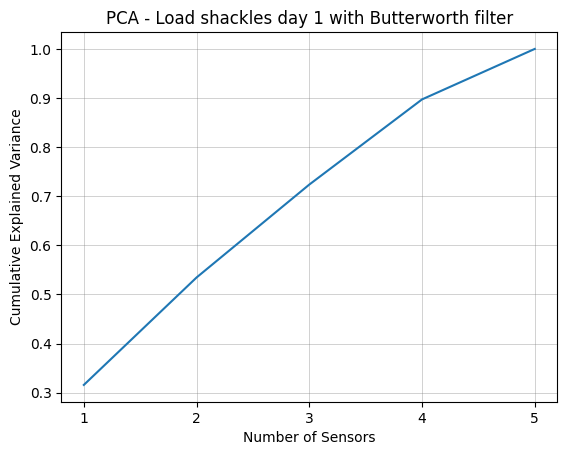

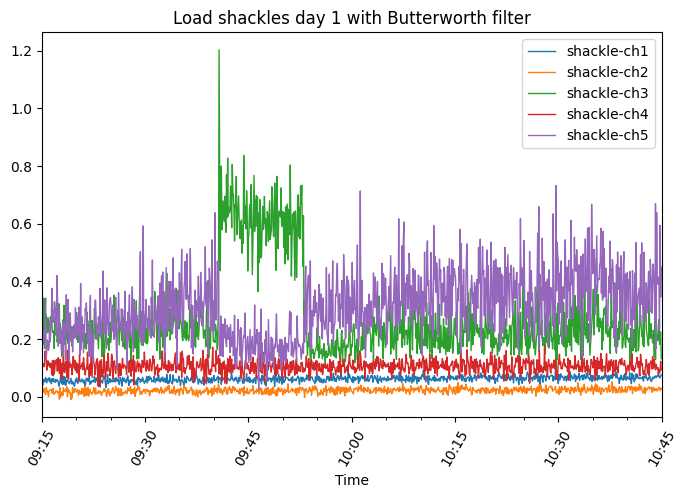

In [152]:
# PCA for shackles
i=0
start = analysis_datetimes[i] - datetime.timedelta(minutes=45)
end = analysis_datetimes[i] + datetime.timedelta(minutes=45)

df_shackles_avg = df_shackles.rolling(window=4*1, axis=0).mean()
df_shackles_filtered = low_pass_filter_dataframe(df_shackles, cutoff_frequency=0.8, sampling_rate=4)

top_sensors_indices = perform_pca(df_shackles_filtered, start, end, save_fig=True, title=f"PCA - Load shackles day {i+1} with Butterworth filter")
plot_sensor_data(df_shackles_filtered[::4*5], start, end, selected_sensors=None, save_fig=True, title=f"Load shackles day {i+1} with Butterworth filter")

In [ ]:
# Plot shackles data
start = analysis_datetimes[0] - datetime.timedelta(minutes=45)
end = analysis_datetimes[0] + datetime.timedelta(minutes=45)
plot_sensor_data(df_shackles[::4*5], start, end, save_fig=True, ylabel="Force [tons]", title="Load shackles preprocessed day 1")